# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [112]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [113]:
modelname = "Base_Code_1"
moddir="C:\\Users\sitzk\Desktop\GW_Modelling\mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nrow = 50
ncol = 50

dx = 1000
dy = 1000

nlay=3  #3 layers

with open('Base_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
zbot = 0

#dz = (ztop - zbot) / nlay
#Lx = dx*ncol
#Ly = dy*nrow

K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)

Ss = 0.0001
n = 0.1 
Sy = 0.1 
uncnf = 1

## Setting up Layer properties

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value for 30 R columns

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[1,:,21:-1] = 0.0001                    # Horizontal K does not change

#model timing (1stress period)
nper = 1
steady = [True]


#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\sitzk\AppData\Local\Temp\ipykernel_7268\1592166835.py:2: DeprecationWarning: invalid escape sequence \s
  moddir="C:\\Users\sitzk\Desktop\GW_Modelling\mf2005.exe"


4. boundaries

In [114]:
#Create bas object
# Our Boundary Conditions 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = 0 # whole left side is no flow
ibound[:, :, -1] = -1 # whole right side constant head
ibound[:, 0, :] = 0 # first row (top of domain) is no flow
ibound[:, -1, :] = 0 # last row (bottom of domain) is no flow
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
h_right = 70
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value


bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)


lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 



recharge & ET

In [115]:
# Rch object
#recharge = 4e-5 #m/day
#rech_zone = np.zeros((nrow,ncol))
#rech_zone[:, 0:15] = rech_zone[:, 0:15] + recharge                # recharge occurs on first 15 columns
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)

#rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
#rech_zone = recharge+rech_zone
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#ET
#ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_zone[:,:,25:-1] = 1e-5  # ET only on right half of domain
#ET_zone[:,22:29,:] = 5e-4  #stream ET

ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,25:-1] = 1e-5  # ET only on right half of domain
ET_zone[21:28,:] = 5e-4  #stream ET
extinction_depth = 1 #extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#print(strt)
#print(ET_zone)
#print(rech_zone)

run model

In [116]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:\Users\sitzk\Desktop\GW_Modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Base_Code_1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20  9:40:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20  9:40:30
 Elapsed run time:  0.127 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

AttributeError: 'NoneType' object has no attribute 'parent'

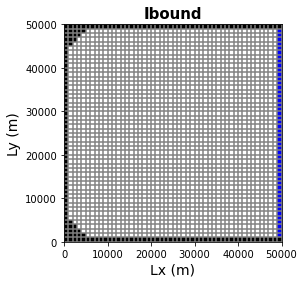

In [117]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
#str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)